## Funnel Definition

We define a standard e-commerce funnel at the **user level**:

1. View: user viewed any product
2. Cart: user added at least one product to cart
3. Purchase: user completed at least one purchase

A user is counted at a given stage if they have performed the corresponding event
at least once during the observation window.

Order constraint:
view → cart → purchase

In [4]:
import duckdb

con = duckdb.connect(database=":memory:")

con.execute("""
CREATE VIEW events AS
SELECT *
FROM read_csv_auto('../data/clean_events.csv')
""")

In [6]:
# SELECT
#   user_id,
#   event_type
# FROM events
# WHERE event_type IN ('view', 'cart', 'purchase')

df_events = con.execute("""
SELECT user_id, event_type
FROM events
WHERE event_type IN ('view', 'cart', 'purchase')
""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [7]:
user_funnel = (
    df_events
    .groupby("user_id")["event_type"]
    .apply(set)
    .reset_index()
)

user_funnel["view"] = user_funnel["event_type"].apply(lambda x: "view" in x)
user_funnel["cart"] = user_funnel["event_type"].apply(lambda x: "cart" in x)
user_funnel["purchase"] = user_funnel["event_type"].apply(lambda x: "purchase" in x)


In [8]:
user_funnel.head()

user_funnel[["view", "cart", "purchase"]].sum()

view        5316128
cart        1054127
purchase     697470
dtype: int64

In [9]:
# Phase 3.1 — Ordered Funnel (Strict Order)

user_funnel_ordered = con.execute("""
WITH first_times AS (
  SELECT
    user_id,
    MIN(CASE WHEN event_type='view' THEN event_time END)     AS t_view,
    MIN(CASE WHEN event_type='cart' THEN event_time END)     AS t_cart,
    MIN(CASE WHEN event_type='purchase' THEN event_time END) AS t_purchase
  FROM events
  WHERE event_type IN ('view','cart','purchase')
  GROUP BY user_id
)
SELECT
  user_id,
  t_view,
  t_cart,
  t_purchase,
  (t_view IS NOT NULL) AS has_view,
  (t_cart IS NOT NULL AND t_view < t_cart) AS has_cart_after_view,
  (t_purchase IS NOT NULL AND t_cart < t_purchase) AS has_purchase_after_cart
FROM first_times
""").df()

user_funnel_ordered.head()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,user_id,t_view,t_cart,t_purchase,has_view,has_cart_after_view,has_purchase_after_cart
0,545003099,2019-10-01 03:12:49-04:00,NaT,NaT,True,False,False
1,549044776,2019-10-01 03:14:31-04:00,NaT,NaT,True,False,False
2,514608645,2019-10-01 03:10:46-04:00,2019-11-21 06:56:31-05:00,2019-11-21 06:56:59-05:00,True,True,True
3,547878580,2019-10-01 03:10:20-04:00,NaT,NaT,True,False,False
4,534189874,2019-10-01 03:06:05-04:00,2019-10-27 05:29:30-04:00,2019-10-27 05:44:27-04:00,True,True,True


In [10]:
# Phase 3.2 — Conversion Rates (User-level)

view_users = user_funnel_ordered["has_view"].sum()
view_to_cart_users = user_funnel_ordered["has_cart_after_view"].sum()
view_to_cart_to_purchase_users = user_funnel_ordered["has_purchase_after_cart"].sum()

conversion_table = {
    "Stage": ["view", "view → cart", "view → cart → purchase"],
    "Users": [
        int(view_users),
        int(view_to_cart_users),
        int(view_to_cart_to_purchase_users)
    ],
    "Conversion Rate": [
        None,
        view_to_cart_users / view_users if view_users else 0,
        view_to_cart_to_purchase_users / view_users if view_users else 0
    ]
}

import pandas as pd
conversion_df = pd.DataFrame(conversion_table)
conversion_df


,Stage,Users,Conversion Rate
0,view,5316128,NaN
1,view → cart,1051433,0.197782
2,view → cart → purchase,467485,0.087937


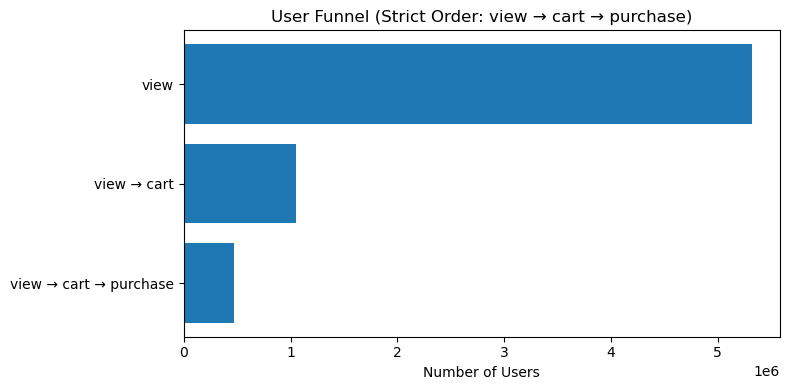

In [13]:
# 3.3 Funnel Visualization

import matplotlib.pyplot as plt

stages = conversion_df["Stage"]
users = conversion_df["Users"]

plt.figure(figsize=(8, 4))
plt.barh(stages, users)
plt.xlabel("Number of Users")
plt.title("User Funnel (Strict Order: view → cart → purchase)")
plt.gca().invert_yaxis()   # 漏斗从上到下
plt.tight_layout()
plt.show()


### Funnel Drop-off Analysis

Using a strict user-level funnel with enforced event order (view → cart → purchase), we observe a significant drop-off at the **view → cart** stage.

Out of approximately 5.3 million users who viewed a product, only about 1.05 million proceeded to add an item to the cart, corresponding to a conversion rate of roughly 19.8%. In contrast, the subsequent transition from cart to purchase shows a comparatively smaller relative drop.

This indicates that the primary bottleneck in the funnel occurs **before cart addition**, suggesting potential issues related to product attractiveness, pricing perception, trust signals, or UI friction on the product detail page.

As a result, optimization efforts are likely to yield the highest impact when focused on improving the view-to-cart transition rather than downstream checkout steps.
